## Cleaning and preprocessing of raw data

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import MinMaxScaler
import string
from nltk.corpus import stopwords
from tensorflow.keras.regularizers import l2

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define directories for each dataset
directories = [
    'agoda_hotel_reviews',  
    'tripadvisor_hotel_reviews',
    'klook_hotel_reviews',  
    'booking_hotel_reviews'
]

In [3]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to load and normalize data
def load_and_normalize_data(directories):
    hotel_dfs = {}
    
    for directory in directories:           
        path = os.path.join('../raw data', directory)
        
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                # Extract hotel name from filename by removing undesired part
                hotel_name = os.path.splitext(filename)[0].replace('_reviews_2022_2024', '')
                
                df = pd.read_csv(os.path.join(path, filename))
                
                # Normalize the Review Score
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])

                # Add a new column for hotel name
                df['Hotel'] = hotel_name
                
                # Concatenate to the hotel DataFrame
                if hotel_name in hotel_dfs:
                    hotel_dfs[hotel_name] = pd.concat([hotel_dfs[hotel_name], df], ignore_index=True)
                else:
                    hotel_dfs[hotel_name] = df.reset_index(drop=True)

    return hotel_dfs


# Load and normalize data
hotel_dfs = load_and_normalize_data(directories)


In [4]:
print(list(hotel_dfs))

['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']


In [5]:
# Function to lemmatize text and check if it's in English
# for identifying english reviews
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
def preprocess_text(text):
    try:
        # Check if the review is in English
        lang = detect(text)
        if lang != 'en':
            return None  # Return None if not in English

        # Step 1: Convert text to lowercase
        text = text.lower()

        # Step 2: Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Step 3: Tokenization
        tokens = nltk.word_tokenize(text)

        # Step 4: Remove stop words
        tokens = [word for word in tokens if word not in stop_words]

        # Step 5: Lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Return the processed text as a single string
        return ' '.join(lemmatized_tokens)

    except LangDetectException as e:
        # If language detection fails, return None
        print(f"error: {e}")
        return None

# Loop through each hotel DataFrame and preprocess the review content
for hotel, df in hotel_dfs.items():
    # Apply preprocessing to the DataFrame's 'Review Content' column
    df['cleaned_content'] = df['Review Content'].apply(preprocess_text)

    # Identify and print the removed reviews (non-English)
    removed_reviews = df[df['cleaned_content'].isnull()]['Review Content']
    print(f"Removed reviews from {hotel}:")
    print(removed_reviews)

    # Drop rows where 'cleaned_content' is None (non-English reviews)
    df = df.dropna(subset=['cleaned_content'])

    # Update the DataFrame in the dictionary
    hotel_dfs[hotel] = df

# Display the cleaned DataFrames for each hotel
for hotel_name, df in hotel_dfs.items():
    print(f"\nCleaned DataFrame for {hotel_name}:")
    print(df)

error: No features in text.
Removed reviews from bai_hotel:
11                                    Excellent\r\n \r\n 
31      Napakaganda ang mura pa dito ulit ako mag ssta...
43                                        Good \r\n \r\n 
45                   No frills, reliable hotel.\r\n \r\n 
47                            Great experience \r\n \r\n 
                              ...                        
3897                              \r\n nice room\r\n none
3905        \r\n friendly.   Amazzzzzinnng breakfast\r\n 
3978    \r\n La gentillesse du personnel, la piscine, ...
4022                                       \r\n Good\r\n 
4032                           \r\n \r\n slow internet. 😔
Name: Review Content, Length: 168, dtype: object
error: No features in text.
error: No features in text.
Removed reviews from dusit_thani_mactan:
6                                     Excellent\r\n \r\n 
10                                        全てが最高\r\n \r\n 
19                              beautifu

In [6]:
# Train/Test Split and creation of labels
train_test_splits = {}
for hotel, df in hotel_dfs.items():
    df['label'] = df['normalized_score'].apply(lambda x: 0 if x <= 0.25 else (2 if x >= 0.75 else 1))

    # Perform 70-30 train-test split
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

    train_test_splits[hotel] = {
        'train': train_df,
        'test': test_df
    }

    print(f"\nTrain DataFrame for {hotel}:")
    print(train_df[['normalized_score', 'label']].describe())
    
    print(f"\nTest DataFrame for {hotel}:")
    print(test_df[['normalized_score', 'label']].describe())


Train DataFrame for bai_hotel:
       normalized_score        label
count       2709.000000  2709.000000
mean           0.910397     1.878922
std            0.178989     0.385428
min            0.000000     0.000000
25%            0.888889     2.000000
50%            1.000000     2.000000
75%            1.000000     2.000000
max            1.000000     2.000000

Test DataFrame for bai_hotel:
       normalized_score        label
count       1162.000000  1162.000000
mean           0.910972     1.887263
std            0.173579     0.378391
min            0.000000     0.000000
25%            0.888889     2.000000
50%            1.000000     2.000000
75%            1.000000     2.000000
max            1.000000     2.000000

Train DataFrame for dusit_thani_mactan:
       normalized_score        label
count       1283.000000  1283.000000
mean           0.815549     1.685892
std            0.259901     0.594052
min            0.000000     0.000000
25%            0.750000     2.000000
50%     

In [7]:
# Count the occurrences of each label
positive_count = 0
negative_count = 0
neutral_count = 0

for hotel, df in hotel_dfs.items():
    neutral_count += (df['label'] == 1).sum()
    negative_count += (df['label'] == 0).sum()
    positive_count += (df['label'] == 2).sum()

# Print the counts
print(f'Positive reviews: {positive_count}')
print(f'Negative reviews: {negative_count}')
print(f'Neutral reviews: {neutral_count}')
print(f"Total: {positive_count+negative_count+neutral_count}")

Positive reviews: 8017
Negative reviews: 385
Neutral reviews: 1406
Total: 9808


In [8]:
from sklearn.utils import shuffle
# Initialize combined lists
combined_X_train = []
combined_y_train = []

raw_train_data = {}
raw_test_data = {}

for hotel_name, df in hotel_dfs.items():
    # Split the dataset into training and testing sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['cleaned_content'], 
        df['label'], 
        test_size=0.3, 
        stratify=df['label'], 
        random_state=42
    )
    
    # Store raw train/test data
    raw_train_data[hotel_name] = (X_train_raw, y_train)
    raw_test_data[hotel_name] = (X_test_raw, y_test)

    # Add to combined lists
    combined_X_train.extend(X_train_raw)  # Use extend to flatten the list for strings
    combined_y_train.extend(y_train.tolist())  # Ensure y_train is a list to extend it
    
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_X_train)  # Fit tokenizer on combined training data

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(combined_X_train)
X_test_sequences = []

# Optionally convert test texts into sequences for padding later
for hotel_name, (test_data, _) in raw_test_data.items():
    sequences = tokenizer.texts_to_sequences(test_data)
    X_test_sequences.append(sequences)

# Pad sequences to ensure uniform input size
X_train_padded = pad_sequences(X_train_sequences, maxlen=100)

# Pad test sequences for each hotel
X_test_padded = []
for sequences in X_test_sequences:
    padded_sequences = pad_sequences(sequences, maxlen=100)
    X_test_padded.append(padded_sequences)
    
# Shuffle the padded training data and corresponding labels
X_train_padded, combined_y_train = shuffle(X_train_padded, combined_y_train, random_state=42)

# Store the processed data in a combined format if desired
train_data = (X_train_padded, np.array(combined_y_train))  # Now a tuple of padded data and labels


# Prepare test data dictionary if needed
test_data = {}
for i, hotel_name in enumerate(raw_test_data.keys()):
    test_data[hotel_name] = X_test_padded[i], raw_test_data[hotel_name][1]  # Corresponding labels    


In [9]:
from sklearn.model_selection import KFold
# Model creation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
def kfold_validation(df, text_column, label_column, num_words=5000, maxlen=100, k=5, epochs=10, learning_rate=1e-4):
    # Prepare data
    X = df[text_column].values
    y = df[label_column].values

    # Tokenization
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    # K-Fold Cross-Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracy_results = []
    val_accuracy_results = []

    for fold, (train_index, val_index) in enumerate(kf.split(padded_sequences)):
        print(f"Training Fold {fold + 1}/{k}")
        
        # Split data into training and validation sets
        X_train, X_val = padded_sequences[train_index], padded_sequences[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create and compile the model
        model = Sequential([
            Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
            Conv1D(filters=64, kernel_size=5, activation='relu'),
            MaxPooling1D(pool_size=2),
            Bidirectional(LSTM(64, return_sequences=True)),
            Bidirectional(LSTM(64)),
            Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
            Dropout(0.5),
            Dense(3, activation='softmax')  # Assuming 3 classes for multi-class classification
        ])
        
        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
        
        # Early Stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        X_train_padded, y_train = train_data
        # Model Training
        history = model.fit(
            X_train_padded, 
            y_train, 
            epochs=10, 
            batch_size=32, 
            validation_split=0.2, 
            callbacks=[early_stopping]
        )

        # Store accuracy results for each fold
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        accuracy_results.append(accuracy)
        val_accuracy_results.append(val_accuracy)

    return accuracy_results, val_accuracy_results, tokenizer


In [10]:
import pandas as pd

# Create DataFrame from combined training data
train_df = pd.DataFrame({
    'cleaned_content': combined_X_train,
    'label': combined_y_train
})

# Call the kfold_validation function
accuracy_results, val_accuracy_results, tokenizer = kfold_validation(
    df=train_df,
    text_column='cleaned_content',
    label_column='label',
    num_words=5000,
    maxlen=100,
    k=5,
    epochs=20,
    learning_rate=1e-4
)

# Print results
print("Training Accuracies per Fold:", accuracy_results)
print("Validation Accuracies per Fold:", val_accuracy_results)


Training Fold 1/5


c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.7786 - loss: 0.9023 - val_accuracy: 0.8157 - val_loss: 0.6317
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8203 - loss: 0.6421 - val_accuracy: 0.8157 - val_loss: 0.6067
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8239 - loss: 0.5930 - val_accuracy: 0.8376 - val_loss: 0.4914
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8595 - loss: 0.4544 - val_accuracy: 0.8361 - val_loss: 0.4851
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8773 - loss: 0.4004 - val_accuracy: 0.8332 - val_loss: 0.5087
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9028 - loss: 0.3478 - val_accuracy: 0.8237 - val_loss: 0.5396
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9123 - loss: 0.3102 - val_accuracy: 0.8310 - val_loss: 0.5734
Training Fold 2/5
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.7871

Average Training Accuracy: 0.8527
Average Validation Accuracy: 0.8268


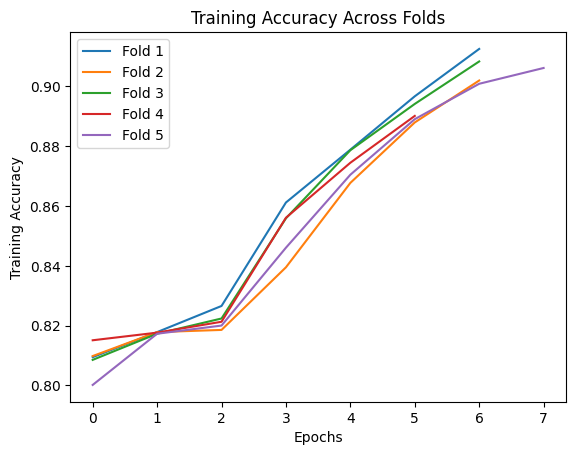

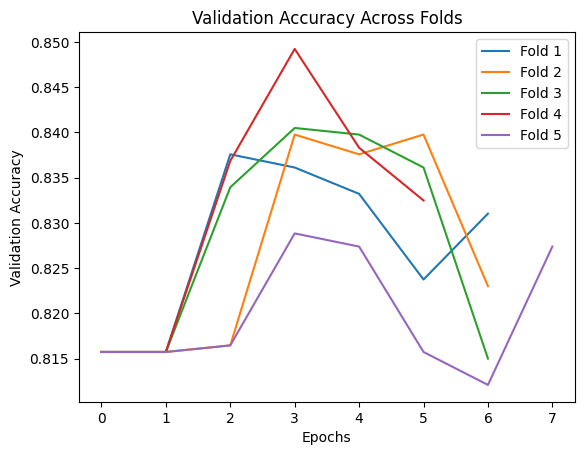

In [12]:
import numpy as np

# Assuming accuracy_results and val_accuracy_results are lists of results from K-Fold
average_accuracy = np.mean([np.mean(acc) for acc in accuracy_results])
average_val_accuracy = np.mean([np.mean(val_acc) for val_acc in val_accuracy_results])

print(f'Average Training Accuracy: {average_accuracy:.4f}')
print(f'Average Validation Accuracy: {average_val_accuracy:.4f}')
import matplotlib.pyplot as plt

for fold in range(len(accuracy_results)):
    plt.plot(accuracy_results[fold], label=f'Fold {fold + 1}')

plt.title('Training Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

for fold in range(len(val_accuracy_results)):
    plt.plot(val_accuracy_results[fold], label=f'Fold {fold + 1}')

plt.title('Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()